In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam


In [2]:
file_path = "cleaned_coin_Bitcoin.csv"
df = pd.read_csv(file_path)
df = df.sort_values('Date')

In [3]:
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

In [4]:
X_train = train_df.drop(['Close', 'Date'], axis=1).values
y_train = train_df['Close'].values.reshape(-1, 1)
X_test = test_df.drop(['Close', 'Date'], axis=1).values
y_test = test_df['Close'].values.reshape(-1, 1)

In [5]:
X_train_scaled = X_train
X_test_scaled = X_test
y_train_scaled = y_train
y_test_scaled = y_test


In [6]:
lookback = 30  # Number of days to look back

def create_sequences(data, target, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create training sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, lookback)

# Create test sequences (combine train and test for continuity)
X_full_scaled = np.concatenate([X_train_scaled, X_test_scaled], axis=0)
y_full_scaled = np.concatenate([y_train_scaled, y_test_scaled], axis=0)

X_test_seq, y_test_seq = [], []
for i in range(len(X_train_scaled), len(X_full_scaled)):
    if i >= lookback:
        X_test_seq.append(X_full_scaled[i-lookback:i])
        y_test_seq.append(y_full_scaled[i])
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

In [7]:
n_features = X_train_seq.shape[2]

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                    input_shape=(lookback, n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))

cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


C:\Users\Aleix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
history = cnn_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: nan - val_loss: nan 
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: nan - val_loss: nan
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: nan - val_loss: nan
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan - val_loss: nan
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan - val_loss: nan
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: nan - val_loss: nan
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan - val_loss: nan
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: nan - val_loss: nan
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: nan - val_loss: nan
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: nan - val_loss: nan
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: nan - val_loss: nan
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan - val_loss: nan
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/s

In [9]:
feature_extractor = Model(inputs=cnn_model.inputs, 
                         outputs=cnn_model.layers[-2].output)

# Generate CNN features
train_cnn_features = feature_extractor.predict(X_train_seq)
test_cnn_features = feature_extractor.predict(X_test_seq)

32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

C:\Users\Aleix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 30, 12))
  warnings.warn(msg)
C:\Users\Aleix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 30, 12))
  warnings.warn(msg)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [10]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_cnn_features, y_train_seq.ravel())


RandomForestRegressor(random_state=42)

In [11]:
y_pred_scaled = rf_model.predict(test_cnn_features)
y_pred = y_pred_scaled.reshape(-1, 1)  # No inverse transform needed if data is already scaled
y_test_actual = y_test_seq.reshape(-1, 1)  # No inverse transform needed if data is already scaled

In [12]:
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

In [13]:
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Squared Error (MSE): 0.2921
Mean Absolute Error (MAE): 0.4736
Root Mean Squared Error (RMSE): 0.5405
R-squared (R²): -3.3053


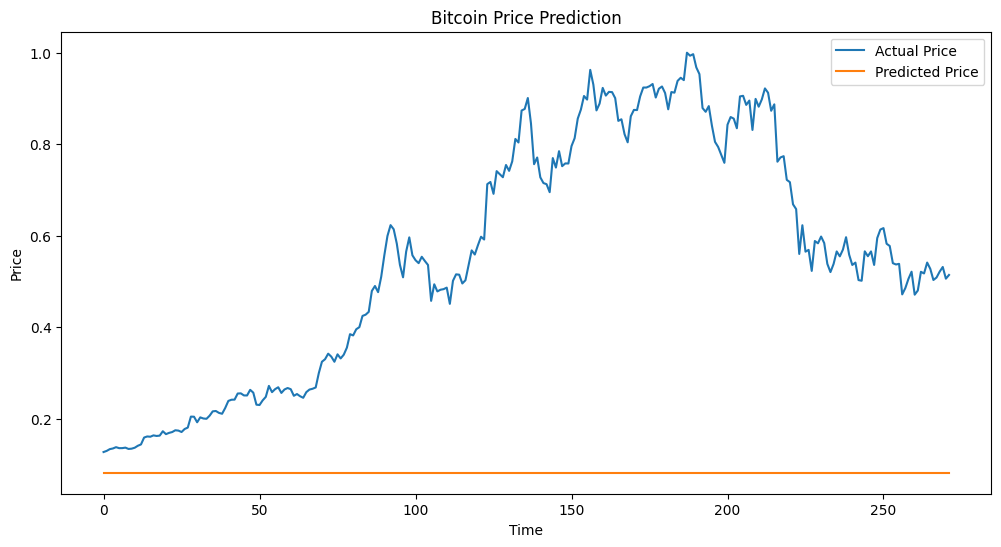

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()